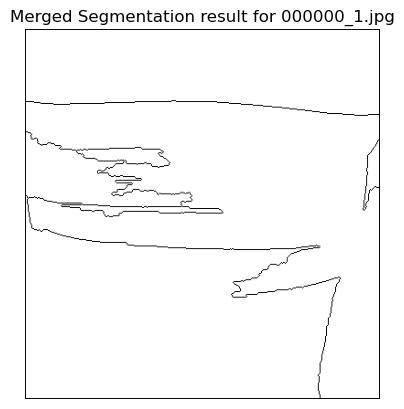

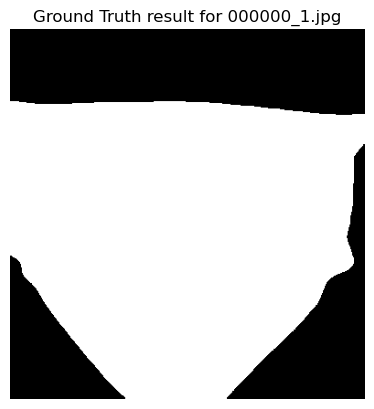

Jaccard Score for 000000_1.jpg: 0.6358821752460039


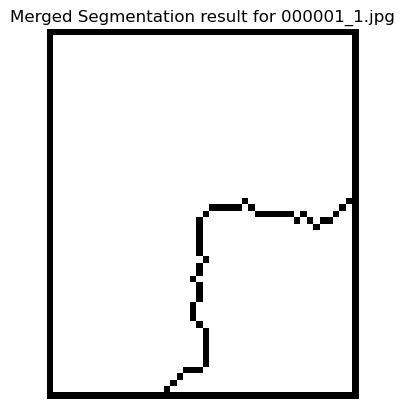

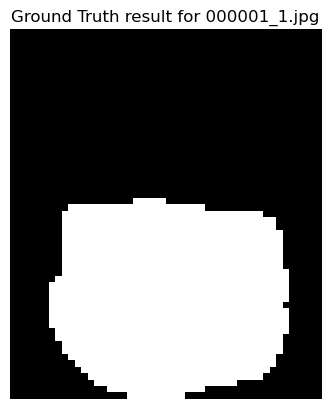

Jaccard Score for 000001_1.jpg: 0.35889328063241105


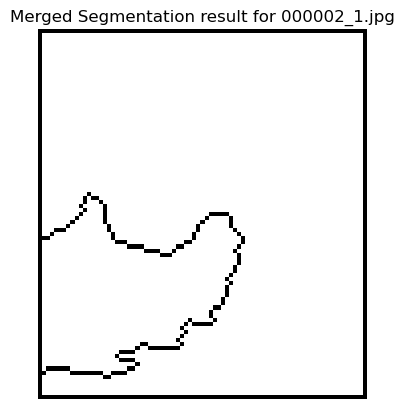

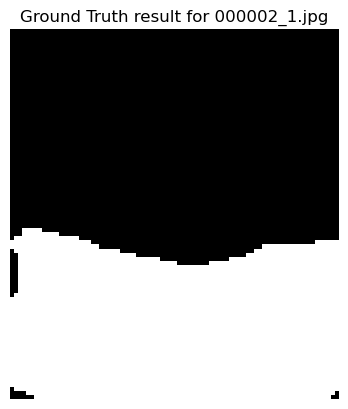

Jaccard Score for 000002_1.jpg: 0.3881227132001126
Average Jaccard score: 0.0027657963381570554


In [10]:
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from matplotlib import pyplot as plt
import os

# Path to the dataset and segmentation results
path_to_data = '../../proj_try/dataset2/1/face_crop/'
path_to_segmented_op = '../../proj_try/dataset2/1/face_crop_segmentation/'
image_names = os.listdir(path_to_data)
image_names = sorted(image_names)
ans_names = os.listdir(path_to_segmented_op)
ans_names = sorted(ans_names)

def watershed_segmentation_and_merge(img_name, ans_name, show=False, save=True, color_threshold=30):
    # Load the image and the segmentation mask
    img = cv2.imread(path_to_data + img_name)
    seg = cv2.imread(path_to_segmented_op + ans_name)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image to reduce noise
    gray_img = cv2.blur(gray_img, (5, 5))

    # Apply Otsu's Thresholding to separate the foreground and background
    ret, img_bin = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise removal using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel, iterations=5)

    # Sure background by dilating the binary image
    sure_bg = cv2.dilate(img_bin, kernel, iterations=3)

    # Distance transform to find sure foreground
    dist = cv2.distanceTransform(img_bin, cv2.DIST_L2, 5)
    
    # Threshold to obtain the sure foreground
    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)

    # Unknown area by subtracting sure foreground from sure background
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so background is not 0, but 1
    markers += 1
    
    # Mark unknown areas as 0
    markers[unknown == 255] = 0

    # Watershed Algorithm
    markers = cv2.watershed(img, markers)
    
    # Mark boundaries with -1
    img[markers == -1] = [255, 0, 0]

    # Merge regions based on color similarity
    def merge_regions(markers, img, color_threshold):
        unique_labels = np.unique(markers)
        
        # Create a list of the region centers (mean color)
        region_centers = []
        for label in unique_labels:
            if label == 0:  # Skip the background
                continue
            region_mask = (markers == label)
            region_color = np.mean(img[region_mask], axis=0)
            region_centers.append((label, region_color))
        
        # Merging process: Merge regions with similar mean color
        new_labels = markers.copy()
        merged_label = unique_labels.max() + 1  # New label for merged regions

        for i in range(len(region_centers)):
            for j in range(i + 1, len(region_centers)):
                label_i, color_i = region_centers[i]
                label_j, color_j = region_centers[j]
                # Calculate the color distance between regions
                color_dist = np.linalg.norm(color_i - color_j)
                if color_dist < color_threshold:
                    # Merge regions if color distance is small
                    new_labels[markers == label_j] = label_i

        return new_labels

    # Merge regions until only two remain
    merged_markers = merge_regions(markers, img, color_threshold)
    
    # Convert to binary image (two regions: mask and non-mask)
    binary_image = np.zeros_like(merged_markers, dtype=np.uint8)
    binary_image[merged_markers > 0] = 1  # All non-zero regions become 1 (mask)
    
    # Convert the ground truth segmentation to binary
    seg = seg.reshape(-1, 3)
    seg2 = np.zeros((seg.shape[0]))
    for i in range(seg.shape[0]):
        val = seg[i][0]
        if abs(255 - val) < abs(val - 0):
            val = 1  # Mask area
        else:
            val = 0  # Non-mask area
        seg2[i] = val
    seg = seg2

    # Calculate the Jaccard score
    s1 = jaccard_score(y_true=seg, y_pred=binary_image.flatten())
    s2 = jaccard_score(y_true=seg, y_pred=1 - binary_image.flatten())

    score = max(s1, s2)

    # Show the results if required
    if show:
        plt.title('Merged Segmentation result for ' + img_name)
        plt.axis('off')
        plt.imshow(binary_image, cmap='gray')
        plt.show()

        plt.title('Ground Truth result for ' + ans_name)
        plt.axis('off')
        plt.imshow(seg.reshape(img.shape[:2]), cmap='gray')
        plt.show()

    # Save the results if required
    if save:
        plt.title('Merged Segmentation result for ' + img_name)
        plt.axis('off')
        plt.imshow(binary_image, cmap='gray')
        plt.savefig(f'./output/watershed/{img_name}')
        plt.close()

    return binary_image, score


# Compute the average Jaccard score over a set of images
tot = 0
count = 3
for i in range(count):  # Change range to process more or fewer images
    seg_pred, score = watershed_segmentation_and_merge(image_names[i], ans_names[i], show=True, save=False)
    print(f'Jaccard Score for {image_names[i]}: {score}')
    tot += score

print('Average Jaccard score:', tot / 500)
